# GAE Benchmark results -- variable training size and variable total embedding

In [1]:
import re

import numpy as np
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
threshold = 10

filepaths = {
    8: '../data/behaviour/gae-benchmarks/git=15257d5eec-dataset=cora,citeseer-clean-testprop=0.15,0.1:0.1:0.9-testtype=nodes,edges-diml1enc=32-diml1dec=32-dimxiadj=8-dimxifeat=8-overlap=0,4,8-bias=false-sharedl1=false-decadjdeep=true,false-nepochs=200-nsamples=10.csv.gz',
    16: '../data/behaviour/gae-benchmarks/git=15257d5eec-dataset=cora,citeseer-clean,pubmed-testprop=0.15,0.1:0.1:0.9-testtype=nodes,edges-diml1enc=32-diml1dec=32-dimxiadj=16-dimxifeat=16-overlap=0,8,16-bias=false-sharedl1=false-decadjdeep=true,false-nepochs=200-nsamples=10.csv.gz',
    24: '../data/behaviour/gae-benchmarks/git=15257d5eec-dataset=cora,citeseer-clean-testprop=0.15,0.1:0.1:0.9-testtype=nodes,edges-diml1enc=32-diml1dec=32-dimxiadj=24-dimxifeat=24-overlap=0,8,16,24-bias=false-sharedl1=false-decadjdeep=true,false-nepochs=200-nsamples=10.csv.gz',
    32: '../data/behaviour/gae-benchmarks/git=15257d5eec-dataset=cora,citeseer-clean-testprop=0.15,0.1:0.1:0.9-testtype=nodes,edges-diml1enc=32-diml1dec=32-dimxiadj=32-dimxifeat=32-overlap=0,8,16,24,32-bias=false-sharedl1=false-decadjdeep=true,false-nepochs=200-nsamples=10.csv.gz'
}

results = {}
for dimξeach, filepath in filepaths.items():
    print("Loading dimxieach = {}".format(dimξeach))
    _results = pd.read_csv(filepath, compression='gzip')
    _results['dimξeach'] = dimξeach

    last_epoch = sorted(np.unique(_results.epoch))[-1]
    _results = _results[_results.epoch == last_epoch]
    exclude_ids = _results['total loss'] > threshold
    print("Excluding the {} / {} points with total loss > {}".format(exclude_ids.sum(), len(_results), threshold))
    results[dimξeach] = _results[~exclude_ids]
    print()

results = pd.concat(results, ignore_index=True)

Loading dimxieach = 8
Excluding the 1 / 2400 points with total loss > 10

Loading dimxieach = 16
Excluding the 107 / 3600 points with total loss > 10

Loading dimxieach = 24
Excluding the 0 / 3200 points with total loss > 10

Loading dimxieach = 32
Excluding the 0 / 4000 points with total loss > 10



In [3]:
results['overlap'] = 2 * results['dimξeach'] - results.dimξ
results.overlap = pd.to_numeric(results.overlap, downcast='integer')
results.testprop = pd.to_numeric(results.testprop * 100, downcast='integer')
results.decadjdeep = results.decadjdeep.map({True: 'Deep', False: 'Shallow'})
results.dataset = results.dataset.map({'cora': 'Cora', 'citeseer-clean': 'CiteSeer', 'pubmed': 'PubMed'})

results.rename(columns={'testprop': 'test size', 'auc': 'AUC', 'ap': 'AP', 'f1micro': 'F1-micro', 'f1macro': 'F1-macro'}, inplace=True)

averages = results.groupby(['dataset', 'decadjdeep', 'dimξ', 'dimξeach', 'testtype', 'test size']).mean().reset_index()
stds = results.groupby(['dataset', 'decadjdeep', 'dimξ', 'dimξeach', 'testtype', 'test size']).std().reset_index()

In [4]:
ylims = {}
palette = sb.color_palette()

## Edge reconstruction

### AUC

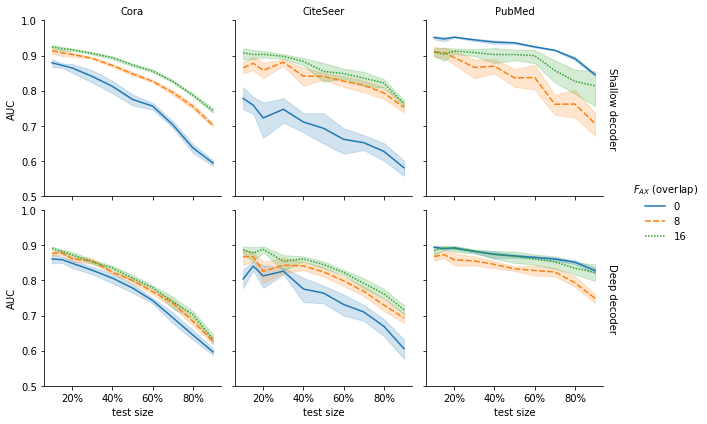

In [5]:
testtype = 'edges'
metric = 'AUC'
dimξeach = 16
ylims['an2vec-{}-{}'.format(testtype, metric)] = [.5, 1]

g = sb.FacetGrid(data=results[(results.testtype == testtype) & (results['dimξeach'] == dimξeach)],
                 col='dataset', col_order=['Cora', 'CiteSeer', 'PubMed'],
                 row='decadjdeep', row_order=['Shallow', 'Deep'],
                 sharey=True, margin_titles=True)
g = g.map_dataframe(sb.lineplot, 'test size', metric, hue='overlap', style='overlap',
                    palette=sb.color_palette()[:3])
g._legend_data.pop('overlap')
g.add_legend(title='$F_{AX}$ (overlap)')
for row in g.axes:
    row[-1].texts = []
g.set_titles(col_template='{col_name}', row_template='{row_name} decoder')
g.set(xticklabels=list(map(lambda t: t.get_text() + '%', g.axes[-1, 0].get_xticklabels())))
g.set(ylim=ylims['an2vec-{}-{}'.format(testtype, metric)])
#g.fig.text(0, 1, 'dimξeach = {}'.format(dimξeach),
#           color='darkred', ha='left', va='center',
#           bbox={'edgecolor': 'darkred', 'facecolor': "#00000000"});
g.fig.savefig('../data/ans-mlg/an2vec-{testtype}-dataset=all-dimxieach={dimxieach}-metric={metric}.pdf'
              .format(testtype=testtype, dimxieach=dimξeach, metric=metric),
              bbox_inches='tight')

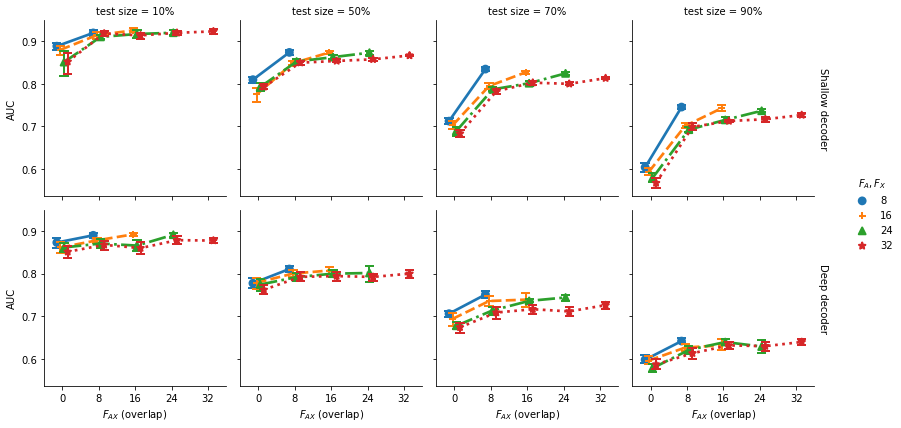

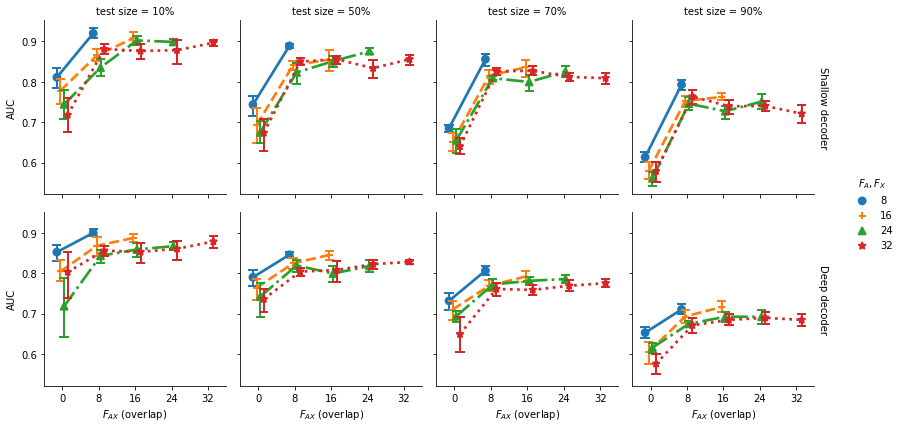

In [6]:
testtype = 'edges'
metric = 'AUC'

datasets = ['Cora', 'CiteSeer']#, 'pubmed']
for dataset in datasets:
    g = sb.FacetGrid(data=results[(results.testtype == testtype) & (results.dataset == dataset) & (results.overlap != 4)],
                     col='test size', col_order=[10, 50, 70, 90],
                     row='decadjdeep', row_order=['Shallow', 'Deep'],
                     sharey=True, margin_titles=True)
    g.map_dataframe(sb.pointplot, 'overlap', metric, hue='dimξeach',
                    linestyles=['-', '--', '-.', ':'],
                    markers=['o', '+', '^', '*'],
                    palette=sb.color_palette(),
                    dodge=.3,
                    scale=1, errwidth=2, capsize=.2)
    g.add_legend(title='$F_A,F_X$')
    for row in g.axes:
        row[-1].texts = []
    for ax in g.axes[-1]:
        ax.set_xlabel('$F_{AX}$ (overlap)')
    g.set_titles(col_template='{col_var} = {col_name}%', row_template='{row_name} decoder')
    #g.fig.text(0, 1, 'dataset = {}'.format(dataset),
    #           color='darkred', ha='left', va='center',
    #           bbox={'edgecolor': 'darkred', 'facecolor': "#00000000"})
    g.fig.savefig('../data/ans-mlg/an2vec-{testtype}-dataset={dataset}-dimxieach=all-metric={metric}.pdf'
                  .format(testtype=testtype, dataset=dataset, metric=metric),
                  bbox_inches='tight')

### AP

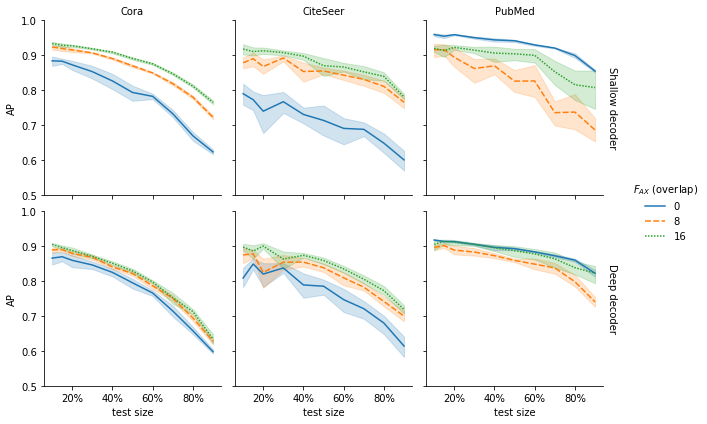

In [7]:
testtype = 'edges'
metric = 'AP'
dimξeach = 16
ylims['an2vec-{}-{}'.format(testtype, metric)] = [.5, 1]

g = sb.FacetGrid(data=results[(results.testtype == testtype) & (results['dimξeach'] == dimξeach)],
                 col='dataset', col_order=['Cora', 'CiteSeer', 'PubMed'],
                 row='decadjdeep', row_order=['Shallow', 'Deep'],
                 sharey=True, margin_titles=True)
g = g.map_dataframe(sb.lineplot, 'test size', metric, hue='overlap', style='overlap',
                    palette=sb.color_palette()[:3])
g._legend_data.pop('overlap')
g.add_legend(title='$F_{AX}$ (overlap)')
for row in g.axes:
    row[-1].texts = []
g.set_titles(col_template='{col_name}', row_template='{row_name} decoder')
g.set(xticklabels=list(map(lambda t: t.get_text() + '%', g.axes[-1, 0].get_xticklabels())))
g.set(ylim=ylims['an2vec-{}-{}'.format(testtype, metric)])
#g.fig.text(0, 1, 'dimξeach = {}'.format(dimξeach),
#           color='darkred', ha='left', va='center',
#           bbox={'edgecolor': 'darkred', 'facecolor': "#00000000"});
g.fig.savefig('../data/ans-mlg/an2vec-{testtype}-dataset=all-dimxieach={dimxieach}-metric={metric}.pdf'
              .format(testtype=testtype, dimxieach=dimξeach, metric=metric),
              bbox_inches='tight')

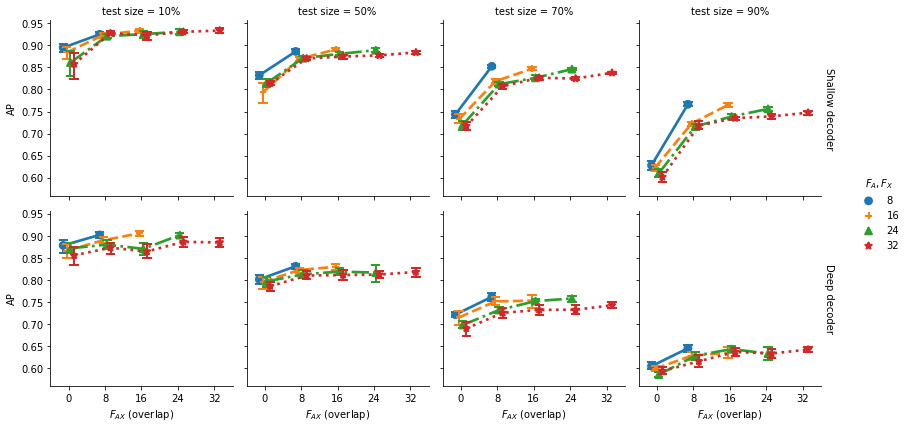

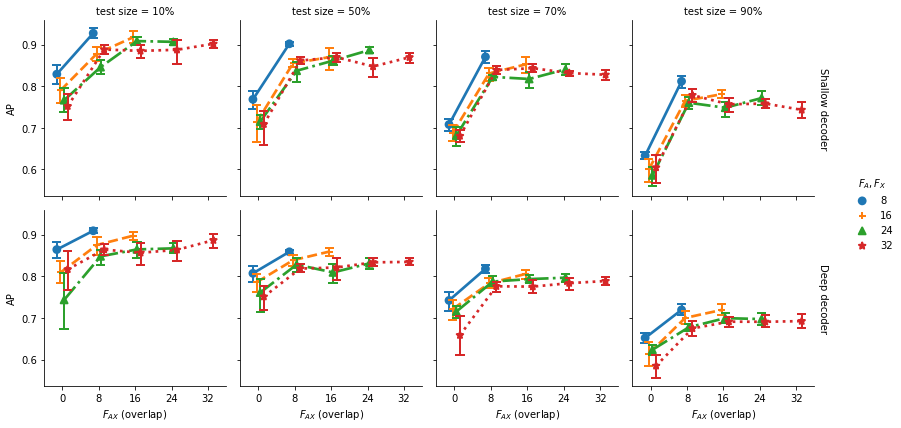

In [8]:
testtype = 'edges'
metric = 'AP'

datasets = ['Cora', 'CiteSeer']#, 'pubmed']
for dataset in datasets:
    g = sb.FacetGrid(data=results[(results.testtype == testtype) & (results.dataset == dataset) & (results.overlap != 4)],
                     col='test size', col_order=[10, 50, 70, 90],
                     row='decadjdeep', row_order=['Shallow', 'Deep'],
                     sharey=True, margin_titles=True)
    g.map_dataframe(sb.pointplot, 'overlap', metric, hue='dimξeach',
                    linestyles=['-', '--', '-.', ':'],
                    markers=['o', '+', '^', '*'],
                    palette=sb.color_palette(),
                    dodge=.3,
                    scale=1, errwidth=2, capsize=.2)
    g.add_legend(title='$F_A,F_X$')
    for row in g.axes:
        row[-1].texts = []
    for ax in g.axes[-1]:
        ax.set_xlabel('$F_{AX}$ (overlap)')
    g.set_titles(col_template='{col_var} = {col_name}%', row_template='{row_name} decoder')
    #g.fig.text(0, 1, 'dataset = {}'.format(dataset),
    #           color='darkred', ha='left', va='center',
    #           bbox={'edgecolor': 'darkred', 'facecolor': "#00000000"})
    g.fig.savefig('../data/ans-mlg/an2vec-{testtype}-dataset={dataset}-dimxieach=all-metric={metric}.pdf'
                  .format(testtype=testtype, dataset=dataset, metric=metric),
                  bbox_inches='tight')

## Node classification

### F1 macro

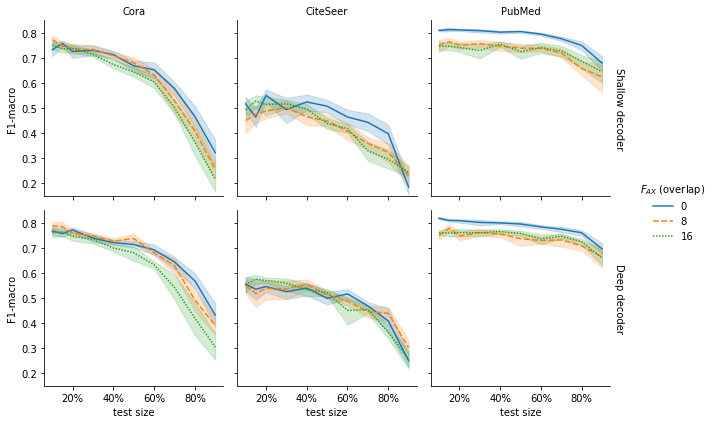

In [9]:
testtype = 'nodes'
metric = 'F1-macro'
dimξeach = 16
ylims['an2vec-{}-{}'.format(testtype, metric)] = [.15, .85]

g = sb.FacetGrid(data=results[(results.testtype == testtype) & (results['dimξeach'] == dimξeach)],
                 col='dataset', col_order=['Cora', 'CiteSeer', 'PubMed'],
                 row='decadjdeep', row_order=['Shallow', 'Deep'],
                 sharey=True, margin_titles=True)
g = g.map_dataframe(sb.lineplot, 'test size', metric, hue='overlap', style='overlap',
                    palette=sb.color_palette()[:3])
g._legend_data.pop('overlap')
g.add_legend(title='$F_{AX}$ (overlap)')
for row in g.axes:
    row[-1].texts = []
g.set_titles(col_template='{col_name}', row_template='{row_name} decoder')
g.set(xticklabels=list(map(lambda t: t.get_text() + '%', g.axes[-1, 0].get_xticklabels())))
g.set(ylim=ylims['an2vec-{}-{}'.format(testtype, metric)])
#g.fig.text(0, 1, 'dimξeach = {}'.format(dimξeach),
#           color='darkred', ha='left', va='center',
#           bbox={'edgecolor': 'darkred', 'facecolor': "#00000000"});
g.fig.savefig('../data/ans-mlg/an2vec-{testtype}-dataset=all-dimxieach={dimxieach}-metric={metric}.pdf'
              .format(testtype=testtype, dimxieach=dimξeach, metric=metric),
              bbox_inches='tight')

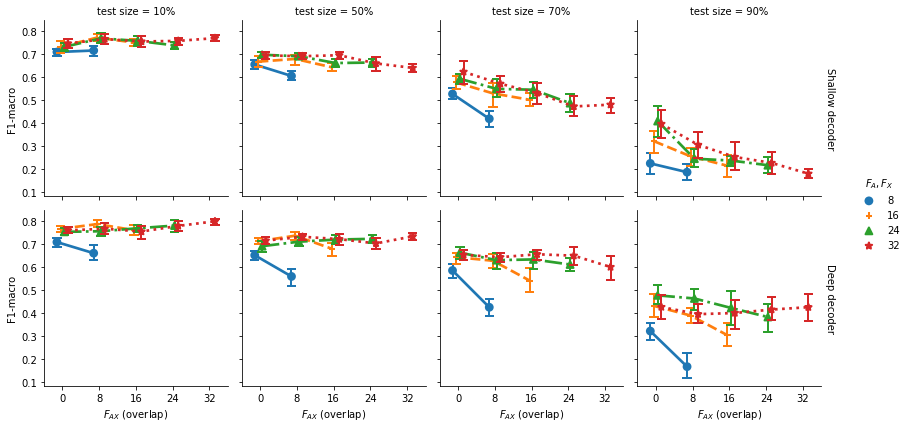

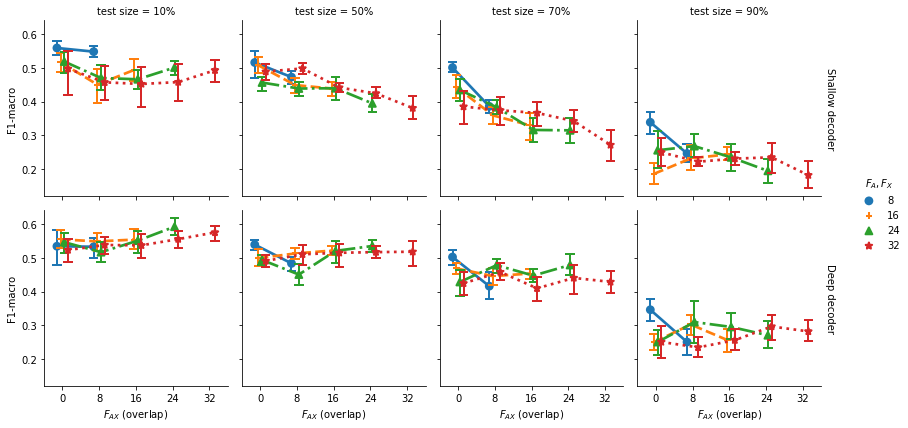

In [10]:
testtype = 'nodes'
metric = 'F1-macro'

datasets = ['Cora', 'CiteSeer']#, 'pubmed']
for dataset in datasets:
    g = sb.FacetGrid(data=results[(results.testtype == testtype) & (results.dataset == dataset) & (results.overlap != 4)],
                     col='test size', col_order=[10, 50, 70, 90],
                     row='decadjdeep', row_order=['Shallow', 'Deep'],
                     sharey=True, margin_titles=True)
    g.map_dataframe(sb.pointplot, 'overlap', metric, hue='dimξeach',
                    linestyles=['-', '--', '-.', ':'],
                    markers=['o', '+', '^', '*'],
                    palette=sb.color_palette(),
                    dodge=.3,
                    scale=1, errwidth=2, capsize=.2)
    g.add_legend(title='$F_A,F_X$')
    for row in g.axes:
        row[-1].texts = []
    for ax in g.axes[-1]:
        ax.set_xlabel('$F_{AX}$ (overlap)')
    g.set_titles(col_template='{col_var} = {col_name}%', row_template='{row_name} decoder')
    #g.fig.text(0, 1, 'dataset = {}'.format(dataset),
    #           color='darkred', ha='left', va='center',
    #           bbox={'edgecolor': 'darkred', 'facecolor': "#00000000"})
    g.fig.savefig('../data/ans-mlg/an2vec-{testtype}-dataset={dataset}-dimxieach=all-metric={metric}.pdf'
                  .format(testtype=testtype, dataset=dataset, metric=metric),
                  bbox_inches='tight')

### F1 micro

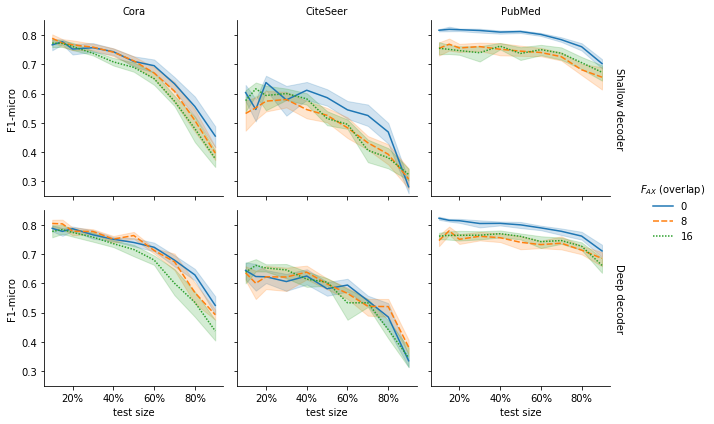

In [11]:
testtype = 'nodes'
metric = 'F1-micro'
dimξeach = 16
ylims['an2vec-{}-{}'.format(testtype, metric)] = [.25, .85]

g = sb.FacetGrid(data=results[(results.testtype == testtype) & (results['dimξeach'] == dimξeach)],
                 col='dataset', col_order=['Cora', 'CiteSeer', 'PubMed'],
                 row='decadjdeep', row_order=['Shallow', 'Deep'],
                 sharey=True, margin_titles=True)
g = g.map_dataframe(sb.lineplot, 'test size', metric, hue='overlap', style='overlap',
                    palette=sb.color_palette()[:3])
g._legend_data.pop('overlap')
g.add_legend(title='$F_{AX}$ (overlap)')
for row in g.axes:
    row[-1].texts = []
g.set_titles(col_template='{col_name}', row_template='{row_name} decoder')
g.set(xticklabels=list(map(lambda t: t.get_text() + '%', g.axes[-1, 0].get_xticklabels())))
g.set(ylim=ylims['an2vec-{}-{}'.format(testtype, metric)])
#g.fig.text(0, 1, 'dimξeach = {}'.format(dimξeach),
#           color='darkred', ha='left', va='center',
#           bbox={'edgecolor': 'darkred', 'facecolor': "#00000000"});
g.fig.savefig('../data/ans-mlg/an2vec-{testtype}-dataset=all-dimxieach={dimxieach}-metric={metric}.pdf'
              .format(testtype=testtype, dimxieach=dimξeach, metric=metric),
              bbox_inches='tight')

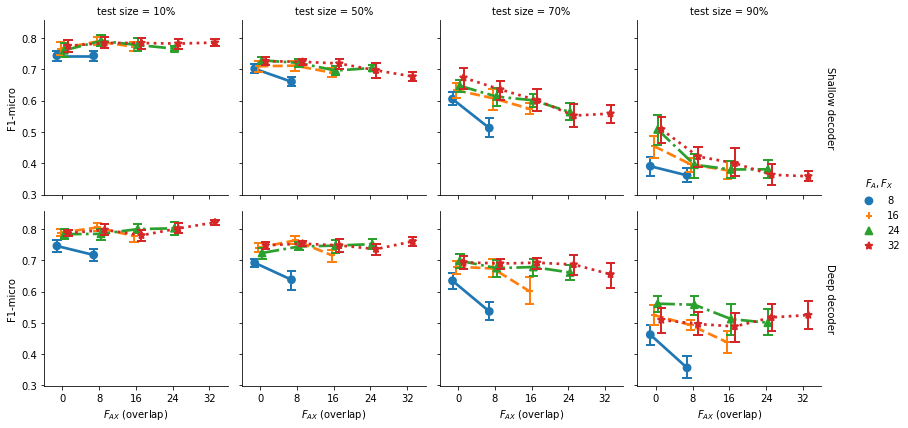

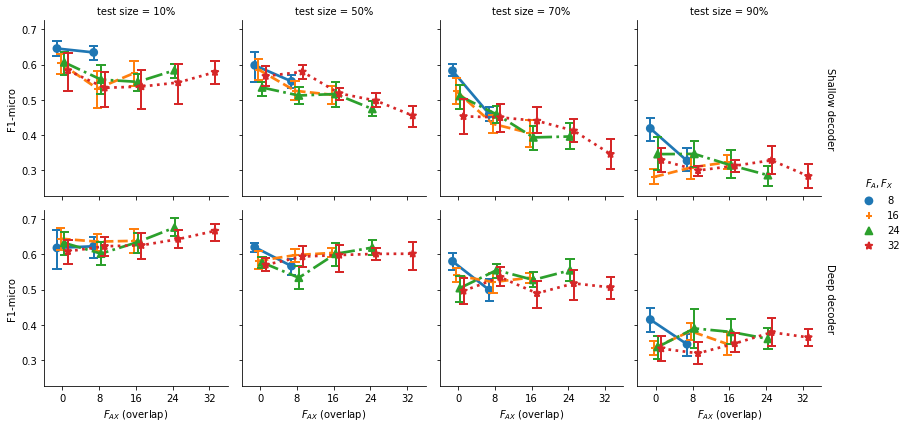

In [12]:
testtype = 'nodes'
metric = 'F1-micro'

datasets = ['Cora', 'CiteSeer']#, 'pubmed']
for dataset in datasets:
    g = sb.FacetGrid(data=results[(results.testtype == testtype) & (results.dataset == dataset) & (results.overlap != 4)],
                     col='test size', col_order=[10, 50, 70, 90],
                     row='decadjdeep', row_order=['Shallow', 'Deep'],
                     sharey=True, margin_titles=True)
    g.map_dataframe(sb.pointplot, 'overlap', metric, hue='dimξeach',
                    linestyles=['-', '--', '-.', ':'],
                    markers=['o', '+', '^', '*'],
                    palette=sb.color_palette(),
                    dodge=.3,
                    scale=1, errwidth=2, capsize=.2)
    g.add_legend(title='$F_A,F_X$')
    for row in g.axes:
        row[-1].texts = []
    for ax in g.axes[-1]:
        ax.set_xlabel('$F_{AX}$ (overlap)')
    g.set_titles(col_template='{col_var} = {col_name}%', row_template='{row_name} decoder')
    #g.fig.text(0, 1, 'dataset = {}'.format(dataset),
    #           color='darkred', ha='left', va='center',
    #           bbox={'edgecolor': 'darkred', 'facecolor': "#00000000"})
    g.fig.savefig('../data/ans-mlg/an2vec-{testtype}-dataset={dataset}-dimxieach=all-metric={metric}.pdf'
                  .format(testtype=testtype, dataset=dataset, metric=metric),
                  bbox_inches='tight')

# GraphSAGE results

In [13]:
gs_filepaths = {
    16: '../data/behaviour/gae-benchmarks/graphsage-git=f31b6c5296-dataset=cora,citeseer-clean,pubmed-testtype=nodes,edges-testprop=0.15,0.1:0.1:0.9-diml1enc=32-dimxiadj=16-bias=false-nepochs=4-nsamples=10.csv',
    32: '../data/behaviour/gae-benchmarks/graphsage-git=f31b6c5296-dataset=cora,citeseer-clean,pubmed-testtype=nodes,edges-testprop=0.15,0.1:0.1:0.9-diml1enc=64-dimxiadj=32-bias=false-nepochs=4-nsamples=10.csv',
}

gs_results = {}
for dimξadj, filepath in gs_filepaths.items():
    print("Loading dimxiadj = {}".format(dimξadj))
    _results = pd.read_csv(filepath)
    _results['dimξadj'] = dimξadj

    gs_results[dimξadj] = _results
    print()

gs_results = pd.concat(gs_results, ignore_index=True)

print('Post-processing')
def make_score_matcher(pattern):
    def _matcher(s):
        m = re.search(pattern, s)
        if m is None:
            return np.nan
        else:
            return float(m.groups()[0])
    return _matcher
# F scores
fscore_error_msg = 'F-score is ill-defined and being set to 0.0 in labels with no predicted samples'
gs_results['f1score_warning'] = gs_results.Stderr.map(lambda s: s.find(fscore_error_msg) != -1)
for f1score in ['f1macro', 'f1micro']:
    pattern = re.compile(r'{}=(0\.[0-9]+)'.format(f1score))
    gs_results[f1score] = gs_results.Stdout.map(make_score_matcher(pattern))
# AUC/AP
for edgescore in ['roc_auc', 'ap']:
    pattern = re.compile(r'{}=(0\.[0-9]+)'.format(edgescore))
    gs_results[edgescore] = gs_results.Stdout.map(make_score_matcher(pattern))
gs_results.tp = pd.to_numeric(gs_results.tp * 100, downcast='integer')
gs_results = gs_results[['dataset', 'dimξadj', 'tt', 'tp', 'sample', 'f1score_warning', 'f1macro', 'f1micro', 'roc_auc', 'ap']]
gs_results.rename(columns={'tt': 'testtype', 'tp': 'test size', 'roc_auc': 'AUC', 'ap': 'AP', 'f1micro': 'F1-micro', 'f1macro': 'F1-macro'}, inplace=True)
gs_results.dataset = gs_results.dataset.map({'cora': 'Cora', 'citeseer-clean': 'CiteSeer', 'pubmed': 'PubMed'})

Loading dimxiadj = 16

Loading dimxiadj = 32

Post-processing


In [14]:
gs_averages = gs_results.groupby(['dataset', 'dimξadj', 'testtype', 'test size']).mean().reset_index()
gs_stds = gs_results.groupby(['dataset', 'dimξadj', 'testtype', 'test size']).std().reset_index()

## Edge reconstruction

### AUC

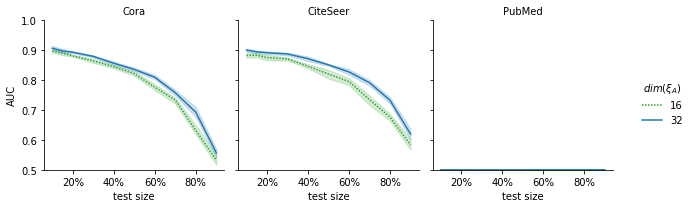

In [15]:
metric = 'AUC'
testtype = 'edges'

g = sb.FacetGrid(data=gs_results[gs_results.testtype == testtype],
                 col='dataset', col_order=['Cora', 'CiteSeer', 'PubMed'],
                 ylim=ylims['an2vec-{}-{}'.format(testtype, metric)],
                 sharey=True, margin_titles=True, dropna=False)
g = g.map_dataframe(sb.lineplot, 'test size', metric, hue='dimξadj', style='dimξadj',
                    dashes=[(1 ,1), ''],
                    palette=[palette[2], palette[0]])
g._legend_data.pop('dimξadj')
g.add_legend(title='$dim(ξ_A)$')
g.set_titles(col_template='{col_name}')
g.set(xticklabels=list(map(lambda t: t.get_text() + '%', g.axes[-1, 0].get_xticklabels())))
g.fig.savefig('../data/ans-mlg/graphsage-{testtype}-dataset=all-metric={metric}.pdf'
              .format(testtype=testtype, metric=metric),
              bbox_inches='tight')

### AP

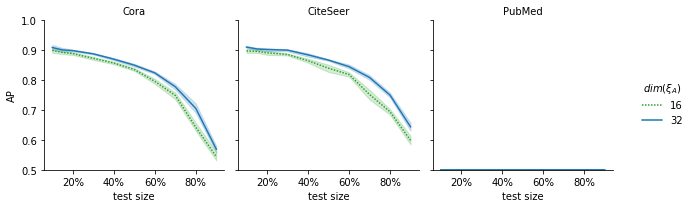

In [16]:
metric = 'AP'
testtype = 'edges'

g = sb.FacetGrid(data=gs_results[gs_results.testtype == testtype],
                 col='dataset', col_order=['Cora', 'CiteSeer', 'PubMed'],
                 ylim=ylims['an2vec-{}-{}'.format(testtype, metric)],
                 sharey=True, margin_titles=True, dropna=False)
g = g.map_dataframe(sb.lineplot, 'test size', metric, hue='dimξadj', style='dimξadj',
                    dashes=[(1 ,1), ''],
                    palette=[palette[2], palette[0]])
g._legend_data.pop('dimξadj')
g.add_legend(title='$dim(ξ_A)$')
g.set_titles(col_template='{col_name}')
g.set(xticklabels=list(map(lambda t: t.get_text() + '%', g.axes[-1, 0].get_xticklabels())))
g.fig.savefig('../data/ans-mlg/graphsage-{testtype}-dataset=all-metric={metric}.pdf'
              .format(testtype=testtype, metric=metric),
              bbox_inches='tight')

## Node classification

### F1 macro

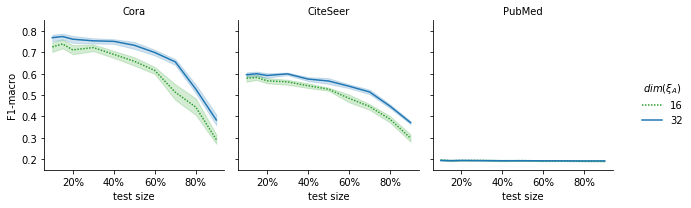

In [17]:
metric = 'F1-macro'
testtype = 'nodes'

g = sb.FacetGrid(data=gs_results[gs_results.testtype == testtype],
                 col='dataset', col_order=['Cora', 'CiteSeer', 'PubMed'],
                 ylim=ylims['an2vec-{}-{}'.format(testtype, metric)],
                 sharey=True, margin_titles=True, dropna=False)
g = g.map_dataframe(sb.lineplot, 'test size', metric, hue='dimξadj', style='dimξadj',
                    dashes=[(1 ,1), ''],
                    palette=[palette[2], palette[0]])
g._legend_data.pop('dimξadj')
g.add_legend(title='$dim(ξ_A)$')
g.set_titles(col_template='{col_name}')
g.set(xticklabels=list(map(lambda t: t.get_text() + '%', g.axes[-1, 0].get_xticklabels())))
g.fig.savefig('../data/ans-mlg/graphsage-{testtype}-dataset=all-metric={metric}.pdf'
              .format(testtype=testtype, metric=metric),
              bbox_inches='tight')

### F1 micro

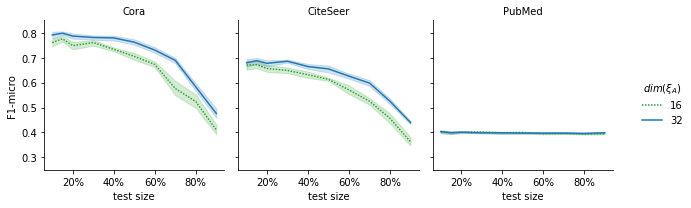

In [18]:
metric = 'F1-micro'
testtype = 'nodes'

g = sb.FacetGrid(data=gs_results[gs_results.testtype == testtype],
                 col='dataset', col_order=['Cora', 'CiteSeer', 'PubMed'],
                 ylim=ylims['an2vec-{}-{}'.format(testtype, metric)],
                 sharey=True, margin_titles=True, dropna=False)
g = g.map_dataframe(sb.lineplot, 'test size', metric, hue='dimξadj', style='dimξadj',
                    dashes=[(1 ,1), ''],
                    palette=[palette[2], palette[0]])
g._legend_data.pop('dimξadj')
g.add_legend(title='$dim(ξ_A)$')
g.set_titles(col_template='{col_name}')
g.set(xticklabels=list(map(lambda t: t.get_text() + '%', g.axes[-1, 0].get_xticklabels())))
g.fig.savefig('../data/ans-mlg/graphsage-{testtype}-dataset=all-metric={metric}.pdf'
              .format(testtype=testtype, metric=metric),
              bbox_inches='tight')